In [90]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns
import ast
import numpy as np
import gensim.downloader as api
from sklearn.metrics.pairwise import cosine_similarity
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler

# Load Datasets

In [20]:
playlist = pd.read_parquet("../cleaned dataset/playlist_cleaned.parquet")
track = pd.read_parquet("../cleaned dataset/track_cleaned.parquet")

# Categorization of `duration`

For tracks being shorter than 180 seconds (3 min), we will classify it as short. <br> <br>
For tracks between 180 seconds (3 min) and 240 seconds (4 min), we will classify it as medium. <br> <br>
For tracks being longer than 240 seconds (4 min), we will classify it as short.

In [87]:
track['category'] = track['duration'].apply(lambda x: 'Short' if x < 180 else 'Medium' if x <= 240 else 'Long')

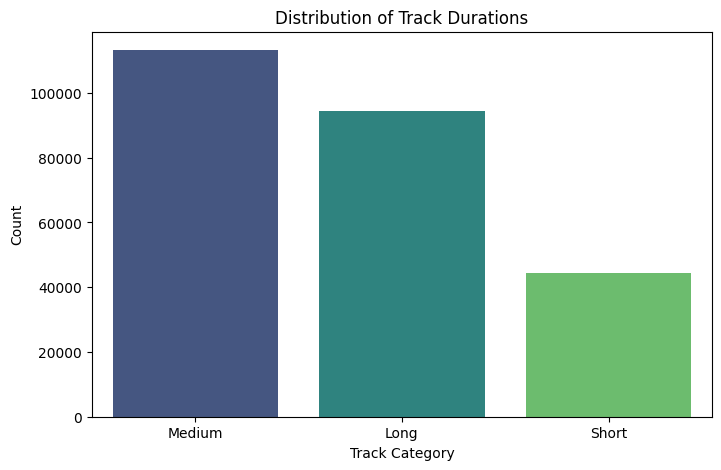

In [88]:
# Count the number of tracks in each category
category_counts = track['category'].value_counts().reset_index()
category_counts.columns = ['category', 'Count']

# Plot the bar chart
plt.figure(figsize=(8, 5))
sns.barplot(data=category_counts, x="category", y="Count", hue="category", palette="viridis", legend=False)

# Labels and title
plt.xlabel("Track Category")
plt.ylabel("Count")
plt.title("Distribution of Track Durations")

plt.show()

In [19]:
track_encoded = pd.get_dummies(track, columns=['category'])

# Sentiment Analysis

In [ ]:
import torch
import pandas as pd
import logging
import pickle
import os
import asyncio
import nest_asyncio
from tqdm.asyncio import tqdm
from transformers import pipeline, AutoTokenizer

# ✅ Fixes event loop issue in Jupyter Notebook
nest_asyncio.apply()

df = pd.read_parquet("/Users/ohungchan/Downloads/tracks_1000playlist_subsample.parquet") # You can change the directory
df = df[:100]

if "lyrics" not in df.columns:
    raise ValueError("❌ The dataset must contain a 'lyrics' column.")

# Drop invalid lyrics
df = df.dropna(subset=["lyrics"])
df = df[~df["lyrics"].isin(["No Lyrics", "none", "None"])].copy()

lyrics_list = df["lyrics"].tolist()
track_idx_list = df["track_idx"].tolist()

logging.info(f"✅ Using {len(df)} valid lyrics for Zero-Shot Classification.")

# -------------------------------
# 3️⃣ Load Zero-Shot Classification Model
# -------------------------------
logging.info("🔹 Loading Zero-Shot Classifier...")
device = 0 if torch.cuda.is_available() else -1
model_name = "MoritzLaurer/mDeBERTa-v3-base-mnli-xnli"

classifier = pipeline(
    "zero-shot-classification",
    model=model_name,
    device=device,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
)

tokenizer = AutoTokenizer.from_pretrained(model_name)

# Define emotion categories
emotions = ["joy", "calm", "sadness", "fear", "energizing", "dreamy"]

# -------------------------------
# 4️⃣ Tokenize Lyrics (Now Asynchronous) & Resume Progress
# -------------------------------
checkpoint_path = "classification_checkpoint.pkl"
start_idx = 0
emotion_scores = {emotion: [] for emotion in emotions}
track_ids = []

if os.path.exists(checkpoint_path):
    logging.info("🔄 Resuming from last checkpoint...")
    with open(checkpoint_path, "rb") as f:
        saved_data = pickle.load(f)
        start_idx = saved_data["last_processed_idx"]
        emotion_scores = saved_data["emotion_scores"]
        track_ids = saved_data["track_ids"]

logging.info(f"🔹 Resuming from batch {start_idx} / {len(lyrics_list)}")

# ✅ **Asynchronous Tokenization**
logging.info("🔹 Tokenizing lyrics asynchronously for faster processing...")

async def tokenize_batch(batch_lyrics):
    return [tokenizer.decode(tokenizer.encode(text, truncation=True, max_length=128)) for text in batch_lyrics]

async def tokenize_all():
    tasks = [tokenize_batch(lyrics_list[i:i+32]) for i in range(0, len(lyrics_list), 32)]
    tokenized_batches = await asyncio.gather(*tasks)
    return [text for batch in tokenized_batches for text in batch]  # Flatten the list

tokenized_lyrics = asyncio.run(tokenize_all())  # ✅ Fast asynchronous tokenization
logging.info("✅ Tokenization complete.")

# -------------------------------
# 5️⃣ Perform Optimized Zero-Shot Classification with asyncio
# -------------------------------
batch_size = 16  # ✅ Increase batch size for faster processing
logging.info("🔹 Running Zero-Shot Classification with asyncio...")

async def classify_batch(batch_lyrics):
    """Runs zero-shot classification on a batch asynchronously."""
    return classifier(batch_lyrics, candidate_labels=emotions, multi_label=True)

async def process_batches():
    global emotion_scores, track_ids

    tasks = []
    batch_results = []
    batches_processed = 0

    for i in tqdm(range(start_idx, len(tokenized_lyrics), batch_size), desc="Classifying Emotions"):
        batch_lyrics = tokenized_lyrics[i : i + batch_size]
        batch_track_ids = track_idx_list[i : i + batch_size]

        # Run classification asynchronously
        tasks.append(classify_batch(batch_lyrics))

        if len(tasks) >= 10 or i + batch_size >= len(tokenized_lyrics):  # ✅ Run in chunks of 10
            batch_results.extend(await asyncio.gather(*tasks))
            tasks = []  # Reset tasks after processing

            # ✅ Process gathered results
            for batch_idx, batch_result in enumerate(batch_results):
                batch_track_ids = track_idx_list[start_idx + (batch_idx * batch_size) : start_idx + ((batch_idx + 1) * batch_size)]

                # ✅ Ensure same number of track IDs & results
                if len(batch_result) != len(batch_track_ids):
                    logging.warning(f"⚠️ Mismatch: {len(batch_result)} results for {len(batch_track_ids)} tracks.")

                for idx, lyric_result in enumerate(batch_result):
                    track_ids.append(batch_track_ids[idx])

                    scores_dict = dict(zip(lyric_result["labels"], lyric_result["scores"]))
                    for emotion in emotions:
                        emotion_scores[emotion].append(scores_dict.get(emotion, 0.0))

            # ✅ **Save Progress Every 2 Batches**
            batches_processed += 1
            if batches_processed % 2 == 0:
                with open(checkpoint_path, "wb") as f:
                    pickle.dump({
                        "last_processed_idx": i + batch_size,
                        "emotion_scores": emotion_scores,
                        "track_ids": track_ids
                    }, f)
                logging.info(f"💾 Checkpoint saved at batch {i + batch_size}")

# ✅ **Run asyncio with compatibility fix**
asyncio.run(process_batches())

logging.info("✅ Classification complete. Saving results...")

# -------------------------------
# 6️⃣ Save Results with Expanded Output
# -------------------------------
logging.info(f"🔍 Final Check: track_ids={len(track_ids)}, emotions={len(next(iter(emotion_scores.values())))}")

# ✅ **Ensure all lists have the same length**
min_length = min(len(track_ids), *[len(scores) for scores in emotion_scores.values()])
track_ids = track_ids[:min_length]  # Trim track IDs
emotion_scores = {k: v[:min_length] for k, v in emotion_scores.items()}  # Trim emotion scores

# ✅ Now save DataFrame
output_df = pd.DataFrame({
    "track_idx": track_ids,
    **emotion_scores  # Expands the dictionary into separate columns
})

# Remove duplicates from the output DataFrame
output_df = output_df.drop_duplicates(subset=["track_idx"], keep="first")

output_df.to_csv("full_dataset_emotion_scores.csv", index=False)

# Remove checkpoint after successful completion
if os.path.exists(checkpoint_path):
    os.remove(checkpoint_path)

logging.info("✅ Full dataset emotion scores saved as 'full_dataset_emotion_scores.csv'.")
print("✅ Emotion classification complete! Results saved.")

/Users/ohungchan/Documents/GitHub/bt4222grp9/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use cpu
Classifying Emotions: 100%|██████████| 6/6 [02:06<00:00, 21.02s/it]

✅ Emotion classification complete! Results saved.


In [91]:
emotion_columns = ["joy", "calm", "sadness", "fear", "energizing", "dreamy"]

# Apply Min-Max Scaling
scaler = MinMaxScaler()
output_df[emotion_columns] = scaler.fit_transform(output_df[emotion_columns])

# Save the normalized results
output_df.to_csv("normalized_emotion_scores.csv", index=False)